In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Datos de Volúmenes Anuales de Entrada

In [106]:
df = pd.read_csv(r'Inlet Data.csv')
df

,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,176.0,90.0,913.0,30.0,86.0,1165.0,142.0,42.0,241.0,219.0,...,205.0,586.0,712.0,110.0,14.0,80.0,126.0,70.0,40.0,264.0


### Proyección basada en Series Históricas

El modelo de previsión que se desarrolló se basa en la secuencia de datos históricos de los volúmenes anuales de entrada a la presa CHICAYÁN durante los años 1979-2024. Este método de previsión genera series sintéticas, en las cuales, en cada escenario, **se toma el último año de la serie y se convierte en el siguiente año** (es decir, 2025), creando así una nueva serie.

El objetivo es **calcular la probabilidad de cada escenario**, y basado en esta probabilidad, **seleccionar el escenario base para la planificación o varios escenarios con alta probabilidad como escenarios base para identificar el número de años con déficit**. 
Para cada escenario, se calculó la probabilidad de que se realice una secuencia durante los próximos 10 años dentro de una serie de 46 años.
Los valores en las series son los volúmenes anuales en la entrada de la represa.
Con base en esto, se desarrollarán los sistemas de almacenamiento, suministro y riego.

### Secuencias Sintéticas

Se generan secuencias sintéticas tomando el último elemento e insertándolo en la primera posición de la nueva secuencia, mientras que el resto de elementos se desplaza una posición. Dado que son 46 años, solamente es posible generar 46 secuencias distintas.

Secuencia madre:

In [107]:
secuencia_madre = df.iloc[0].values.astype(np.float32)
secuencia_madre

array([ 176.,   90.,  913.,   30.,   86., 1165.,  142.,   42.,  241.,
        219.,  213.,  753.,  896.,  720., 1505.,  155.,  175.,  100.,
         74.,  685., 1039.,  136.,   40.,   76.,  311.,  111.,  721.,
        110.,  824.,  553.,  311.,  908.,  567.,  321.,  906.,  806.,
        205.,  586.,  712.,  110.,   14.,   80.,  126.,   70.,   40.,
        264.], dtype=float32)

Las secuencias sintéticas estarán sujetas a un factor de decrecimiento anual. Se especifican 46 secuencias con factor de decrecimiento del 0.05% anual.

In [108]:
def shift_sequence(arr_m, num_shifts, factor):

    arr = arr_m.copy()
    sequences = []

    sequences.append(arr)
    
    for j in range(len(arr)):
            sequences[0][j] = sequences[0][j]*(factor**(j+1))

    for i in range(num_shifts-1):
        last_element = arr_m[-(i+1)]
        shifted_arr = np.concatenate(([last_element], arr[:-1]))

        for j in range(len(shifted_arr)):
            shifted_arr[j] = shifted_arr[j]*factor
        
        sequences.append(shifted_arr)
        arr = shifted_arr  # se actualiza el arreglo para la siguiente iteración
    
    return sequences

In [109]:
num_shifts_to_perform = 46
dec_factor = 0.005
result_sequences = shift_sequence(secuencia_madre, num_shifts_to_perform, 1 - dec_factor)

for i, seq in enumerate(result_sequences):
    print(f"Sequence {i+1}: {seq}")

Sequence 1: [ 175.12        89.10225    899.37335     29.404486    83.87139
 1130.484      137.10393     40.34911    230.36938    208.29312
  201.57352    709.042      839.4756     671.2057    1395.9913
  143.05432    160.70538     91.37249     67.277565   619.65814
  935.1908     121.79983     35.644363    67.385666   274.3705
   97.43682    629.7359      95.59583    712.51917    475.79245
  266.24158    773.4361     480.5568     270.70093    760.2143
  672.9239     170.29733    484.36713    585.5718      90.01521
   11.3991995   64.81259    101.56943     56.145325    31.922626
  209.6359   ]
Sequence 2: [ 262.68      174.2444     88.65674   894.87646    29.257463   83.452034
 1124.8315    136.41841    40.147366  229.21754   207.25166   200.56564
  705.49677   835.2782    667.8497   1389.0114    142.33905   159.90186
   90.91563    66.94118   616.5599    930.51483   121.19083    35.46614
   67.04874   272.99866    96.94964   626.5872     95.11785   708.95654
  473.41348   264.91037   

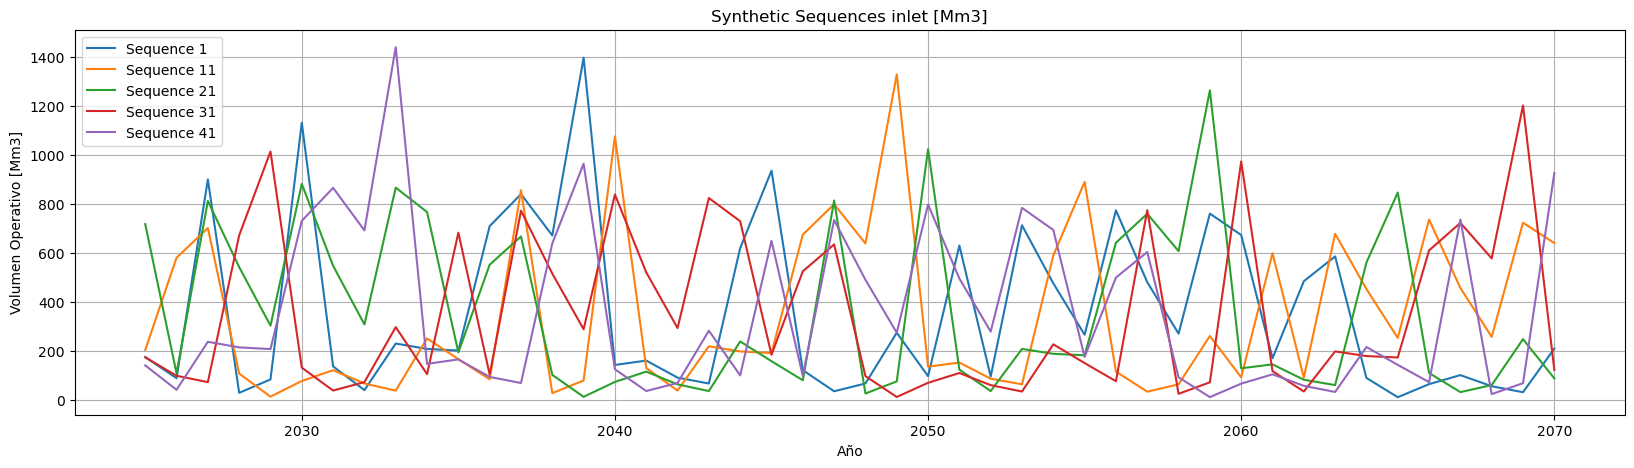

In [110]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(2025,2071,1),result_sequences[0],label="Sequence 1")
plt.plot(np.arange(2025,2071,1),result_sequences[10],label="Sequence 11")
plt.plot(np.arange(2025,2071,1),result_sequences[20],label="Sequence 21")
plt.plot(np.arange(2025,2071,1),result_sequences[30],label="Sequence 31")
plt.plot(np.arange(2025,2071,1),result_sequences[40],label="Sequence 41")



plt.title("Synthetic Sequences inlet [Mm3]")
plt.xlabel("Año")
plt.ylabel("Volumen Operativo [Mm3]")
plt.grid(True)
plt.legend()

### Distribución de Probabilidad

Se proporciona la siguiente distribución de frecuencias, la cual muestra una forma analítica para la distribución de probabilidad (ajuste logarítmico):

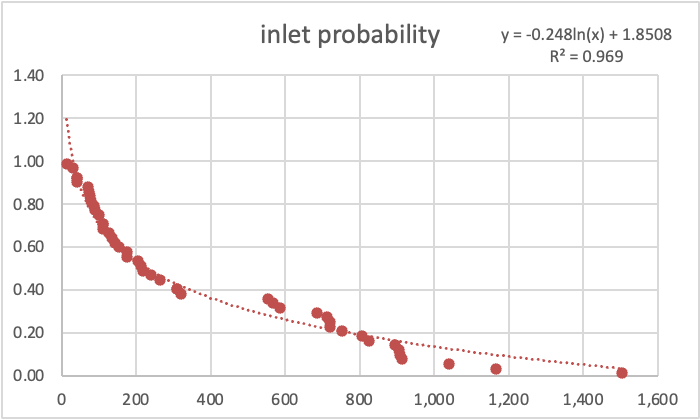


In [111]:
def sequence_probability(sequences,horizon,trials):

    def log_probability(x):
        return -0.248*np.log(x)+1.8508

    probabilities_arrays = []
    probabilities = []
    
    for i in range(len(sequences)):
        
        probability_arr = log_probability(sequences[i])

        for j in range(len(probability_arr)):
            
            if probability_arr[j] >= 1.0:
                probability_arr[j] = 0.99
        
        probabilities_arrays.append(probability_arr)
        probabilities.append(1-(1-np.prod(probability_arr[:horizon]))**(10*trials))
    
    return np.array(probabilities), probabilities_arrays

Se calculan las probabilidades utilizando la función de densidad dada, para un horizonte de tiempo de 10 años.

In [112]:
intentos = 2
horizonte = 10
probabilidades, arreglos_probabilidad = sequence_probability(result_sequences,horizonte,intentos)

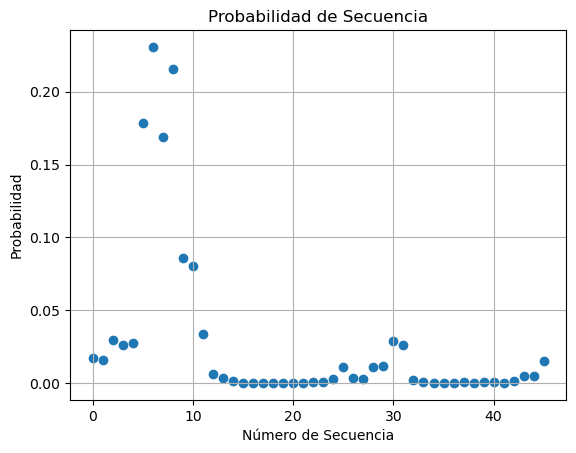

In [113]:
plt.scatter(range(len(probabilidades)),probabilidades)
plt.title("Probabilidad de Secuencia")
plt.xlabel("Número de Secuencia")
plt.ylabel("Probabilidad")
plt.grid(True)

In [114]:
np.where(probabilidades>0.20)

(array([6, 8]),)

**Las secuencias 6 y 8 tienen probabilidades mayores al 20% de ocurrir en los siguientes 10 años.**

### Secuencia 6

In [115]:
probabilidades[6]

np.float32(0.23079449)

In [116]:
arreglos_probabilidad[6][:horizonte]

array([0.99      , 0.7665436 , 0.65513146, 0.8021457 , 0.94217354,
       0.47542334, 0.57722175, 0.7447922 , 0.1714375 , 0.99      ],
      dtype=float32)

In [117]:
result_sequences[6][:horizonte]

array([ 13.93    ,  79.201996, 124.11944 ,  68.610466,  39.00995 ,
       256.17838 , 169.93164 ,  86.46237 , 872.7272  ,  28.533304],
      dtype=float32)

### Secuencia 8

In [118]:
probabilidades[8]

np.float32(0.21592832)

In [119]:
arreglos_probabilidad[8][:horizonte]

array([0.22315979, 0.6875671 , 0.99      , 0.76902986, 0.6576177 ,
       0.8046318 , 0.9446597 , 0.47790945, 0.5797081 , 0.74727833],
      dtype=float32)

In [120]:
result_sequences[8][:horizonte]

array([708.44    , 108.90275 ,  13.791049,  78.41196 , 122.88135 ,
        67.92607 ,  38.620827, 253.623   , 168.23657 ,  85.59991 ],
      dtype=float32)

### Balance Hídrico

Se definen las variables relevantes para el cálculo del balance hídrico de una secuencia.

- Inlet [Mm3]
- Vt [Mm3]
- Over Flow [Mm3]
- Irrigation Outlet [Mm3]
- Loses [Mm3]
- Balance from Previous Year [Mm3]
- Net Volume [Mm3]
- Operative Volume for Next Year [Mm3]
- Historical Volume [Mm3]


In [121]:
def balance_hidrico(inlet_sequence,max_volume,irrigation_outlet,losses):

    balance = []
    max_irrigation_outlet = 0
    min_volume = 135
    balance_previous_year = 229.36

    for i in range(len(inlet_sequence)):
        Vt = inlet_sequence[i] + balance_previous_year
        overflow = max(Vt-max_volume,0)
        net_volume = max(Vt - overflow - irrigation_outlet - losses,0)
        operative_volume = net_volume - min_volume

        registro = [2025+i,inlet_sequence[i],Vt,overflow,balance_previous_year,net_volume,operative_volume]

        balance.append(registro)
    
        balance_previous_year = net_volume

    df = pd.DataFrame(balance,columns=['year','inlet','Vt','overflow','balance_previous_year','net_volume','operative_volume'])
    deficit_count = df[df['operative_volume']<0]['year'].count()

    print("Con una capacidad de",max_volume,"Mm3, un consumo de",irrigation_outlet,"Mm3 y unas pérdidas de",losses,"Mm3, el número de años esperado con déficit en los próximos",horizonte,"años es:",deficit_count)
    
    plt.figure(figsize=(10, 5))
    plt.plot(df['year'],df['operative_volume'])
    plt.title("Volumen Operativo [Mm3]")
    plt.xlabel("Año")
    plt.ylabel("Volumen Operativo [Mm3]")
    plt.grid(True)
    
    return deficit_count,df

### Secuencia 6

Con una capacidad de 250 Mm3, un consumo de 79.2 Mm3 y unas pérdidas de 18 Mm3, el número de años esperado con déficit en los próximos 10 años es: 4


,year,inlet,Vt,overflow,balance_previous_year,net_volume,operative_volume
0,2025,13.930000,243.290009,0.000000,229.360000,146.090012,11.090012
1,2026,79.201996,225.292007,0.000000,146.090012,128.092010,-6.907990
2,2027,124.119438,252.211456,2.211456,128.092010,152.800003,17.800003
3,2028,68.610466,221.410461,0.000000,152.800003,124.210464,-10.789536
4,2029,39.009949,163.220413,0.000000,124.210464,66.020416,-68.979584
5,2030,256.178375,322.198792,72.198792,66.020416,152.800003,17.800003
6,2031,169.931641,322.731628,72.731628,152.800003,152.800003,17.800003
7,2032,86.462372,239.262375,0.000000,152.800003,142.062378,7.062378
8,2033,872.727173,1014.789551,764.789551,142.062378,152.800003,17.800003
9,2034,28.533304,181.333313,0.000000,152.800003,84.133316,-50.866684


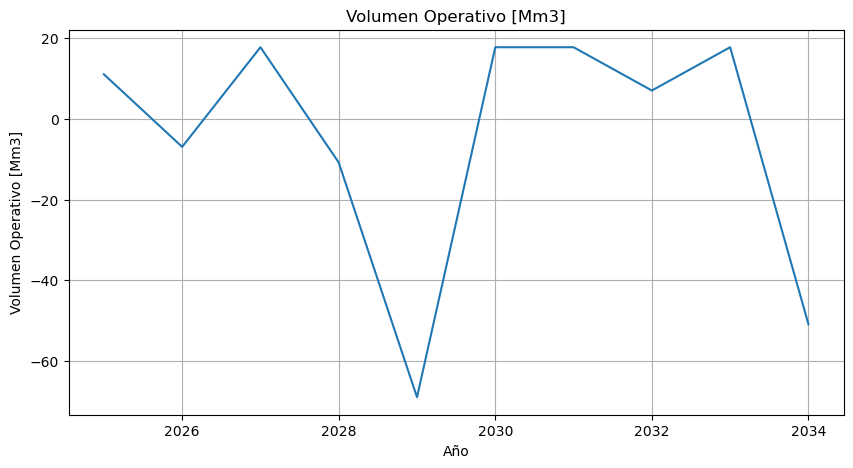

In [122]:
volumen_maximo = 250
salida_irrigacion = 79.2
perdidas = 18
años_deficit_secuencia_6, secuencia_6 = balance_hidrico(result_sequences[6][:horizonte],volumen_maximo,salida_irrigacion,perdidas)
secuencia_6

### Secuencia 8

Con una capacidad de 250 Mm3, un consumo de 79.2 Mm3 y unas pérdidas de 18 Mm3, el número de años esperado con déficit en los próximos 10 años es: 5


,year,inlet,Vt,overflow,balance_previous_year,net_volume,operative_volume
0,2025,708.440002,937.799988,687.799988,229.360000,152.800003,17.800003
1,2026,108.902748,261.702759,11.702759,152.800003,152.800003,17.800003
2,2027,13.791049,166.591049,0.000000,152.800003,69.391052,-65.608948
3,2028,78.411957,147.803009,0.000000,69.391052,50.603012,-84.396988
4,2029,122.881348,173.484360,0.000000,50.603012,76.284363,-58.715637
5,2030,67.926071,144.210434,0.000000,76.284363,47.010437,-87.989563
6,2031,38.620827,85.631264,0.000000,47.010437,0.000000,-135.000000
7,2032,253.623001,253.623001,3.623001,0.000000,152.800003,17.800003
8,2033,168.236572,321.036560,71.036560,152.800003,152.800003,17.800003
9,2034,85.599907,238.399902,0.000000,152.800003,141.199905,6.199905


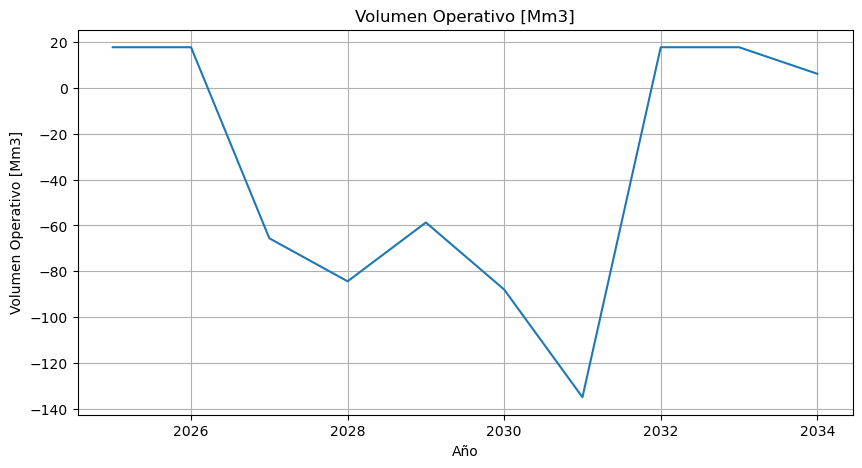

In [123]:
volumen_maximo = 250
salida_irrigacion = 79.2
perdidas = 18
años_deficit_secuencia_8, secuencia_8 = balance_hidrico(result_sequences[8][:horizonte],volumen_maximo,salida_irrigacion,perdidas)
secuencia_8